In [1]:
import numpy as np

In [2]:
class CreateDataset:
    """ create the 2 XOR datasets, X & Y, for the DNN model """
    
    # create the entry dataset X
    def create_X(self, X_size):
        self.X = np.random.randint(2, size=(2, X_size))
        return self.X
    
    # create the label dataset Y
    def create_Y(self, X, X_size):
        self.Y = np.sum(X, axis=0).reshape((1,X_size))
        self.Y[self.Y != 1] = 0
        return self.Y

In [3]:
class Activation:
    """ the abstract class for all activation funtion classes"""
    
    # the basic formula of the activation function for the forward pass
    def formula(self, Z):
        raise NotImplementdError
    
    # to calculate the derivative of the activation function for the backward pass
    def derivative(self, input):
        raise NotImplementdError
    
    # to be used to finetune the initialized weight according to the activation function set for the first layer
    def heuristic(self, layer_b4):
        raise NotImplementdError
    

class Sigmoid(Activation):
    """ all the functions related to the sigmoid activation function """
    
    # the basic formula of the sigmoid function for the forward pass
    def formula(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    # to calculate the derivative of the sigmoid function for the backward pass
    def derivative(self, A):
        return A * (1 - A)
    
    # to be used to finetune the initialized weight if sigmoid function is set for the first layer
    def heuristic(self, layer_b4):
        return np.sqrt(1 / layer_b4)
    

class Tanh(Activation):
    """ all the functions related to the tanh activation function """
    
    # the basic formula of the tanh function for the forward pass
    def formula(self, Z):
        return (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    
    # to calculate the derivative of the tanh function for the backward pass
    def derivative(self, A):
        return 1 - A**2
    
    # to be used to finetune the initialized weight if tanh function is set for the first layer
    def heuristic(self, layer_b4):
        return np.sqrt(1 / layer_b4)
    
    
class Relu(Activation):
    """ all the functions related to the relu activation function """
    
    # the basic formula of the relu function for the forward pass
    def formula(self, Z):
        return (Z > 0) * Z
    
    # to calculate the derivative of the relu function for the backward pass
    def derivative(self, Z):
        return (Z > 0) * 1
    
    # to be used to finetune the initialized weight if relu function is set for the first layer
    def heuristic(self, layer_b4):
        return np.sqrt(2 / layer_b4) 

In [29]:
class Cost:
    """ the abstract class for all the cost functions """
    
    # calculate the cost function
    def formula(self, A, Y):
        raise NotImplementedError
    
    # calculate the derivative of the cost function (dA[L]) for the last layer
    def derivative(self, A, Y):
        raise NotImplementedError

class LossEntropy(Cost):
    """ Use Loss Entropy to calculate the cost """
    
    # calculate the Lose Entropy cost
    def formula(self, A, Y):
        self.m = Y.shape[1]
        return - np.sum((Y * np.log(A) + (1-Y) * np.log(1-A)), axis=1) / self.m
    
    # calculate the derivative of the Lost Entropy cost
    def derivative(self, A, Y):
        return - ((np.divide(Y, A)) - (np.divide(1-Y, 1-A)))

In [30]:
class Layer:
    """ the abstract class for all layer classes """
    
    def __init__(self):
        pass
    
    # implement forward pass
    def forward_pass(self, input):
        raise NotImplementedError
        
    # implement backward pass
    def backward_pass(self, input):
        raise NotImplementedError

        
class FCLayer(Layer):
    
    # initialize parameters
    def __init__(self, layer_b4, layer_after, activation):

        self.activation = activation
        self.W = np.random.randn(layer_after, layer_b4) * getattr(self.activation, 'heuristic')(self, layer_b4)
        self.b = np.zeros((layer_after, 1))
    
    # calculate forward pass: linear fn (Z = WX + b) and non-linear (A = g(Z))
    def forward_pass(self, X):
        self.A_prev = X
        self.Z = np.dot(self.W, X) + self.b
        self.A = getattr(self.activation, 'formula')(self, self.Z)
        return self.A
    
    # calculate backward pass: 
    # dZ = dA * g'(Z))
    # dA[l-1] = W.T * dZ
    def backward_pass(self, dA, learning_rate):
        self.m = dA.shape[1]
        
        self.dZ = dA * getattr(self.activation, 'derivative')(self, self.A)
        pre = np.dot(self.W.T, self.dZ)
        
        self.dW = np.dot(self.dZ, self.A_prev.T) / self.m        
        
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * (np.sum(self.dZ) / self.m)
        
        return np.dot(self.W.T, self.dZ) # dA[l-1]        

In [31]:
class Network:
    """ build the whole L-layer DNN """
    
    def __init__(self):
        self.layers = []
    
    # combine individual layer to form the whole DNN
    def combine(self, layer):
        self.layers.append(layer)
    
    # print cost during training and evaluation
    def print_cost(self,loss_fn, A, Y, epoch_number=-1):
        cost = getattr(loss_fn, 'formula')(A, Y)
        
        # print cost during training
        if epoch_number != -1:
            print(f'cost of {epoch_number}: {cost}')
        
        # if epoch_number == -1, then we print cost during evaluation
        else:
            print(f'cost: {cost}')

    # get the derivative of the cost function for the last layer (dA[L])
    def get_error_derivative(self, loss_fn, A, Y):
        return getattr(loss_fn, 'derivative')(A, Y)
    
    # call forward pass function for the whole
    def forward(self, A):
        for layer in self.layers:
            A = layer.forward_pass(A)
        return A
    
    # call backward pass function
    def backward(self, dA, learning_rate):
        for layer in reversed(self.layers):
            dA = layer.backward_pass(dA, learning_rate)
        
    # train the DNN model
    def fit(self, X, Y, iteration, loss_fn, learning_rate, print_freq=1000):
        for i in range(iteration):
            
            A = self.forward(X)
            if i % print_freq == 0: self.print_cost(loss_fn, A, Y, epoch_number=i)        
            dA = self.get_error_derivative(loss_fn, A, Y)
            self.backward(dA, learning_rate)
            
        return A
    
    # predict the result with the trained DNN model
    def predict(self, X):
        probabilities = self.forward(X)      
        predictions = (probabilities >= 0.5) * 1        
        return predictions
    
    # evaluate the performace of the DNN model
    def evaluate(self, X, Y, loss_func, dataset_name="dataset", print_cost=False):
        Y_hat = self.predict(X)
        accuracy = np.average((Y == Y_hat) * 1)
        print(f'Accuracy of the {dataset_name}: {accuracy * 100}%')
        if print_cost : self.print_cost(loss_fn, self.forward(X), Y)

In [32]:
#
# DATASET CREATION
#
X_size = 4000
ds = CreateDataset()
X = ds.create_X(X_size)
Y = ds.create_Y(X, X_size)


#
# NEURAL NETWORK
#

learning_rate = 0.05
loss_fn = LossEntropy()
iteration = 10000 # 10000 * 1000 * 4

net = Network()
net.combine(FCLayer(2, 3, Relu))
net.combine(FCLayer(3, 1, Sigmoid))

# train the DNN model
A = net.fit(X, Y, iteration, loss_fn, learning_rate)

# predict a result with a test dataset using the trained DNN model
net.evaluate(X, Y, loss_fn, dataset_name="train dataset", print_cost=True)

cost of 0: [0.69588309]
cost of 1000: [0.52046877]
cost of 2000: [0.14940221]
cost of 3000: [0.03375708]
cost of 4000: [0.01548739]
cost of 5000: [0.00942691]
cost of 6000: [0.00661134]
cost of 7000: [0.00502246]
cost of 8000: [0.0040089]
cost of 9000: [0.00331355]
Accuracy of the train dataset: 100.0%
cost: [0.00281026]


# Visualize dataset and NN Predictions

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

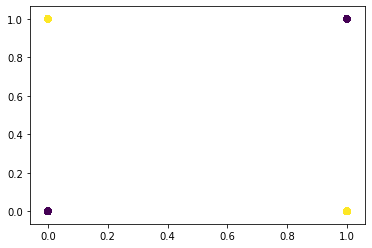

In [34]:
plt.scatter(X[0,:], X[1,:], c=Y[0,:])

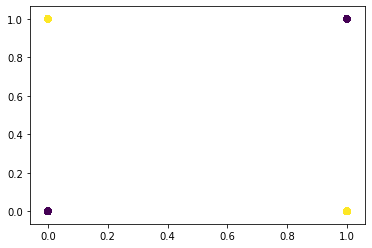

In [35]:
Y_pred = net.predict(X)
plt.scatter(X[0,:], X[1,:], c=Y_pred[0,:])

# Creation dataset (XOR) Noisy 

# Creation dataset MOONS

# Creation dataset CIRCLES